In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ! ln -s /content/drive/MyDrive/XAI-CV-CounterfactualSamples .
! ln -s /content/drive/MyDrive/src/XAI-CV-CounterfactualSamples .

In [3]:
%cd XAI-CV-CounterfactualSamples

/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples


In [ ]:
# ! ln -s /content/drive/MyDrive/datasets/HAM10000 datasets

In [4]:
%cd exp_ham10k

/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples/exp_ham10k


In [ ]:
! pip install tensorflow==2.15.1 > /content/install.log

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.1 which is incompatible.


# Initialization

In [5]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

In [6]:
import importlib
import configs
importlib.reload(configs)

<module 'configs' from '/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples/exp_ham10k/configs.py'>

# Data Loader

In [ ]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, subsets_file,
                       subset, expect_confidence=1,
                       batch_size=16, shuffle=False):
        self.data_dir = data_dir
        self.subsets_file = subsets_file
        self.subset = subset
        self.expect_confidence = expect_confidence
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.filenames = None
        self.classnames = None
        self.dict_class_names = None

        self.load_data()
        self.indices = None
        self.on_epoch_end()

    def load_data(self):
        df_files = pd.read_csv(self.subsets_file)
        self.df_files = df_files[df_files['subset'] == self.subset]
        self.filenames = self.df_files['filename'].tolist()
        self.classnames = self.df_files['classname'].tolist()
        self.dict_class_names = {name:i for i, name in enumerate(configs.CLASS_NAMES)}
        print('*** load_data')
        print(self.subset)
        print(len(self.filenames), 'found')
        print(df_files.head())
        print('***')

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        filenames = [self.filenames[k] for k in indices]
        classnames = [self.classnames[k] for k in indices]
        X, Ys = self.__data_generation(filenames, classnames)
        return X, Ys

    def on_epoch_end(self):
        self.indices = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def toOneHot(self, classname):
        v = np.zeros(configs.NUM_CLASS, dtype=np.float64)
        v[self.dict_class_names[classname]] = 1.0
        return v

    def __data_generation(self, filenames, classnames):
        num = len(filenames)
        X = np.empty([num, *configs.IMAGE_SIZE], dtype=np.float64)
        Y = np.empty([num, configs.NUM_CLASS])
        HH, WW, _ = configs.IMAGE_SIZE
        for i, fn in enumerate(filenames):
            img = plt.imread(configs.DATA_DIR+'/'+fn)
            delta = (WW - HH) // 2
            img = img[:, delta:WW-delta-1]
            img = cv2.resize(img, configs.IMAGE_SIZE[:2])
            X[i] = np.array(img, dtype=np.float64) / 255.
            Y[i] = self.toOneHot(classnames[i])

        return X, {'classifier256':Y, 'out_img':X}

In [ ]:
train_datagen = MyDataGenerator(configs.DATA_DIR,
                                configs.SUBSETS_FILE,
                                'train',
                                expect_confidence=0,
                                shuffle=True)
val_datagen = MyDataGenerator(configs.DATA_DIR,
                              configs.SUBSETS_FILE,
                              'val',
                              expect_confidence=0,
                              shuffle=False)
test_datagen = MyDataGenerator(configs.DATA_DIR,
                               configs.SUBSETS_FILE,
                               'test',
                               expect_confidence=0,
                               shuffle=False)

*** load_data
train
5005 found
                      filename subset classname
0  test/akiec/ISIC_0028232.jpg   test     akiec
1  test/akiec/ISIC_0033000.jpg   test     akiec
2  test/akiec/ISIC_0029059.jpg   test     akiec
3  test/akiec/ISIC_0033413.jpg   test     akiec
4  test/akiec/ISIC_0031198.jpg   test     akiec
***
*** load_data
val
2000 found
                      filename subset classname
0  test/akiec/ISIC_0028232.jpg   test     akiec
1  test/akiec/ISIC_0033000.jpg   test     akiec
2  test/akiec/ISIC_0029059.jpg   test     akiec
3  test/akiec/ISIC_0033413.jpg   test     akiec
4  test/akiec/ISIC_0031198.jpg   test     akiec
***
*** load_data
test
3010 found
                      filename subset classname
0  test/akiec/ISIC_0028232.jpg   test     akiec
1  test/akiec/ISIC_0033000.jpg   test     akiec
2  test/akiec/ISIC_0029059.jpg   test     akiec
3  test/akiec/ISIC_0033413.jpg   test     akiec
4  test/akiec/ISIC_0031198.jpg   test     akiec
***


(16, 256, 256, 3)
[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]


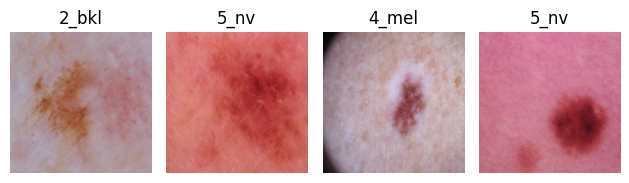

In [ ]:
X, Ys = train_datagen[0]
Y_img, Y_cls = Ys['out_img'], Ys['classifier256']
print(X.shape)
print(Y_cls)

for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow((X[i]*255).astype(np.uint8))
  plt.axis('off')
  class_id = Y_cls[i].argmax()
  plt.title(str(class_id)+'_'+configs.CLASS_NAMES[class_id])
plt.tight_layout()
plt.show()

# Generator 256 x 256

In [ ]:
class GeneratorBuilder():
    def double_conv_block(self, x, n_filters):
        x = tf.keras.layers.Conv2D(n_filters, 3,
                                   padding="same", activation="relu")(x)
        x = tf.keras.layers.Conv2D(n_filters, 3,
                                   padding="same", activation="relu")(x)
        return x

    def downsample_block(self, x, n_filters):
        f = self.double_conv_block(x, n_filters)
        p = tf.keras.layers.MaxPool2D(2)(f)
        p = tf.keras.layers.Dropout(0.5)(p)
        return f, p

    def upsample_block(self, x, conv_features, n_filters):
        x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
        x = tf.keras.layers.concatenate([x, conv_features])
        x = tf.keras.layers.Dropout(0.5)(x)
        x = self.double_conv_block(x, n_filters)
        return x

    def build_unet_model(self, input_shape, classifier, name):
        inputs = tf.keras.layers.Input(shape=input_shape)

        f1, p1 = self.downsample_block(inputs, 64)      # 128
        f2, p2 = self.downsample_block(p1, 128)         # 64
        f3, p3 = self.downsample_block(p2, 256)         # 32
        f4, p4 = self.downsample_block(p3, 512)         # 16
        bottleneck = self.double_conv_block(p4, 512)
        u5 = self.upsample_block(bottleneck, f4, 512)   # 32
        u6 = self.upsample_block(u5, f3, 256)           # 64
        u7 = self.upsample_block(u6, f2, 128)           # 128
        u8 = self.upsample_block(u7, f1, 64)            # 256

        # out_img
        out_img = tf.keras.layers.Conv2D(3, 1, padding="same",
                                activation = "sigmoid", name="out_img")(u8)

        # outputs_class
        classifier.trainable = False
        out_cls = classifier(out_img)

        unet_model = tf.keras.Model(inputs,
                                    outputs=[out_img, out_cls],
                                    name=name)

        return unet_model

In [ ]:
classifier = tf.keras.models.load_model(configs.CLASSIFIER256_CHECKPOINT)

In [ ]:
model = GeneratorBuilder().build_unet_model(
    configs.IMAGE_SIZE,
    classifier,
    'generator256'
)
model.summary()

Model: "generator256"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                    

# Custom Loss

In [ ]:
class CounterfactualCustomLoss(tf.keras.losses.Loss):
    def __init__(self):
        super(CounterfactualCustomLoss, self).__init__()

    def call(self, y_true, y_pred):
        return tf.reduce_mean(
                    tf.square(tf.reduce_sum(y_true * y_pred, axis=1)
                    )
                )

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss={'out_img':tf.losses.MeanSquaredError(),
                    'classifier256':CounterfactualCustomLoss()},
              loss_weights={'out_img':1,
                            'classifier256':1/10},
              metrics=[])

# Training

In [ ]:
cb_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=5,
    verbose=1,
    mode='auto'
)
cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    configs.CHECKPOINTS_DIR + '/' + model.name,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)
cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=1e-4,
    min_lr=0
)

callbacks = [cb_model_checkpoint,
             cb_reduce_lr,
             cb_early_stop]

In [ ]:
model.outputs

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'out_img')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'classifier256')>]

In [ ]:
history = model.fit_generator(train_datagen,
                    epochs=2024,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=val_datagen)

pd.DataFrame.from_dict(history.history) \
            .to_csv(configs.CHECKPOINTS_DIR+'/'+
                    model.name+'/history_generator.csv',
                    index=False)

<ipython-input-19-0cb2258224fc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen,


Epoch 1/2024
313/313 [==============================] - ETA: 0s - loss: 0.0144 - out_img_loss: 0.0115 - classifier256_loss: 0.0294 
Epoch 1: val_loss improved from inf to 0.01036, saving model to checkpoints/generator256
313/313 [==============================] - 9903s 32s/step - loss: 0.0144 - out_img_loss: 0.0115 - classifier256_loss: 0.0294 - val_loss: 0.0104 - val_out_img_loss: 0.0047 - val_classifier256_loss: 0.0563 - lr: 1.0000e-04
Epoch 2/2024
313/313 [==============================] - ETA: 0s - loss: 0.0047 - out_img_loss: 0.0023 - classifier256_loss: 0.0238
Epoch 2: val_loss improved from 0.01036 to 0.00551, saving model to checkpoints/generator256
313/313 [==============================] - 420s 1s/step - loss: 0.0047 - out_img_loss: 0.0023 - classifier256_loss: 0.0238 - val_loss: 0.0055 - val_out_img_loss: 0.0028 - val_classifier256_loss: 0.0272 - lr: 1.0000e-04
Epoch 3/2024
313/313 [==============================] - ETA: 0s - loss: 0.0036 - out_img_loss: 0.0013 - classifier2

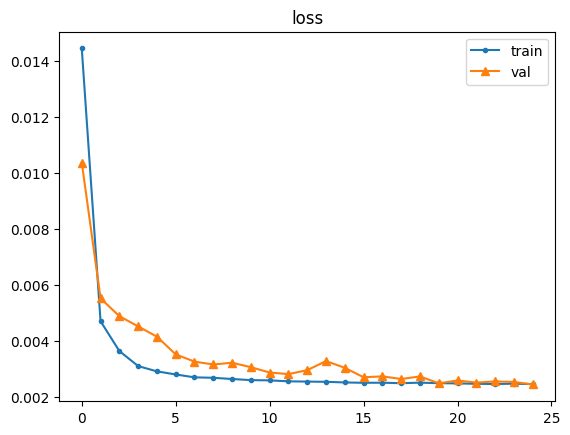

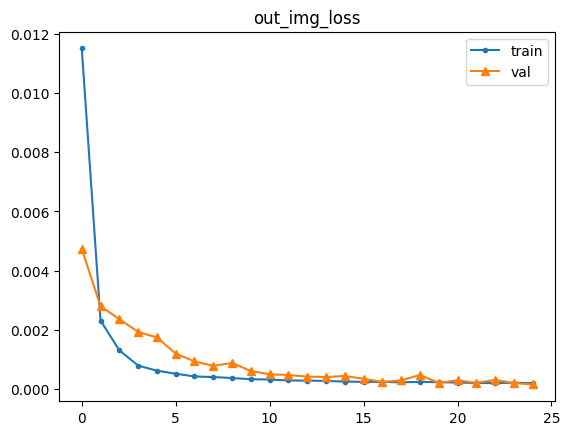

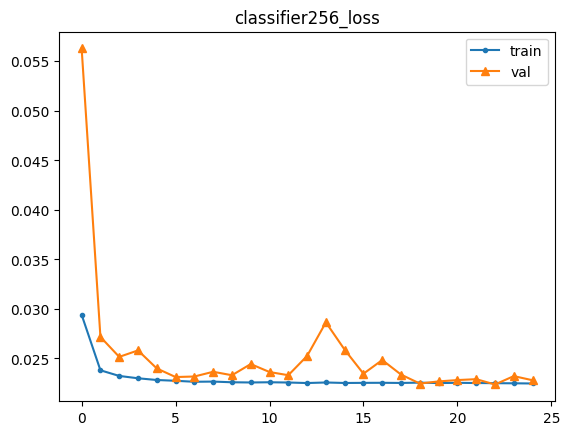

In [ ]:
df = pd.read_csv('checkpoints/generator256/history_generator.csv')

plt.plot(df['loss'], label='train', marker='.')
plt.plot(df['val_loss'], label='val', marker='^')
plt.legend()
plt.title('loss')
plt.show()

plt.plot(df['out_img_loss'], label='train', marker='.')
plt.plot(df['val_out_img_loss'], label='val', marker='^')
plt.legend()
plt.title('out_img_loss')
plt.show()

plt.plot(df['classifier256_loss'], label='train', marker='.')
plt.plot(df['val_classifier256_loss'], label='val', marker='^')
plt.legend()
plt.title('classifier256_loss')
plt.show()

# Evaluation - Images

In [ ]:
model.load_weights('checkpoints/generator256-20241003211500-label-target-zero-onetenth-weighted')
# classifier = tf.keras.models.load_model(configs.CLASSIFIER256_CHECKPOINT)

In [ ]:
train_loss = model.evaluate_generator(train_datagen, verbose=1)
val_loss = model.evaluate_generator(val_datagen, verbose=1)
test_loss = model.evaluate_generator(test_datagen, verbose=1)
print(train_loss, val_loss, test_loss)

<ipython-input-22-35ee51f7a147>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss = model.evaluate_generator(train_datagen, verbose=1)


313/313 [==============================] - 98s 311ms/step - loss: 0.0025 - out_img_loss: 1.5880e-04 - classifier256_loss: 0.0231


<ipython-input-22-35ee51f7a147>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss = model.evaluate_generator(val_datagen, verbose=1)


125/125 [==============================] - 40s 315ms/step - loss: 0.0024 - out_img_loss: 1.5845e-04 - classifier256_loss: 0.0228


<ipython-input-22-35ee51f7a147>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss = model.evaluate_generator(test_datagen, verbose=1)


189/189 [==============================] - 4420s 24s/step - loss: 0.0025 - out_img_loss: 1.5967e-04 - classifier256_loss: 0.0230
[0.0024646685924381018, 0.00015879582497291267, 0.023058714345097542] [0.002438121708109975, 0.00015845097368583083, 0.022796714678406715] [0.002461591036990285, 0.0001596679794602096, 0.023019231855869293]


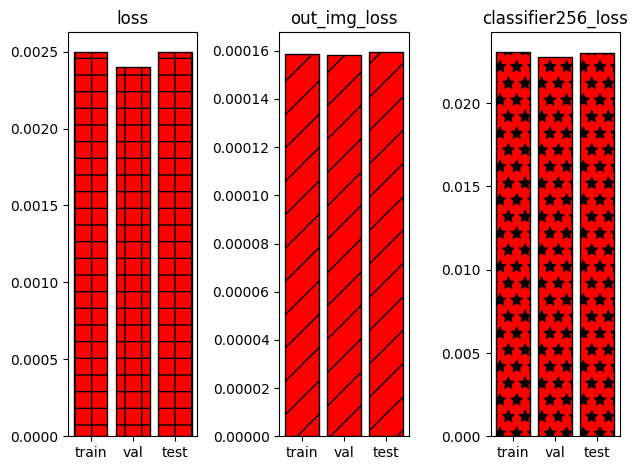

In [ ]:
plt.subplot(1, 3, 1)
plt.bar(['train', 'val', 'test'], [0.0025, 0.0024, 0.0025], color='red',
                                edgecolor='black', hatch='+')
plt.title('loss')

plt.subplot(1, 3, 2)
plt.bar(['train', 'val', 'test'], [1.5880e-04, 1.5845e-04, 1.5967e-04], color='red',
                                edgecolor='black', hatch='/')
plt.title('out_img_loss')

plt.subplot(1, 3, 3)
plt.bar(['train', 'val', 'test'], [0.0231, 0.0228, 0.0230], color='red',
                                edgecolor='black', hatch='*')
plt.title('classifier256_loss')
plt.tight_layout()
plt.show()

In [ ]:
def plot_generated_images(X, generator, classifier, num=-1):
  X_, Y_ = generator.predict(X, verbose=0)
  Y_cls_original = classifier.predict(X)
  Y_cls_counter = classifier.predict(X_)
  D = X - X_
  print(X_.shape, Y_.shape)

  num = 4 if num > 0 else X.shape[0]
  np.set_printoptions(precision=4)
  for i in range(num):
    print(f'*** sample {i}')
    print(Y_cls_original[i])
    print(Y_cls_counter[i])

    plt.subplot(1, 3, 1)
    plt.imshow((X[i]*255).astype(np.uint8))
    plt.axis('off')
    plt.title('original')

    plt.subplot(1, 3, 2)
    plt.imshow((X_[i]*255).astype(np.uint8))
    plt.axis('off')
    plt.title('counterfactual')

    heatmap = (D[i]**2).sum(axis=2)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    plt.subplot(1, 3, 3)
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title('difference')

    plt.show()

## train

1/1 [==============================] - 0s 38ms/step
(16, 256, 256, 3) (16, 7)
*** sample 0
[0.1149 0.1148 0.3117 0.1147 0.1147 0.1147 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


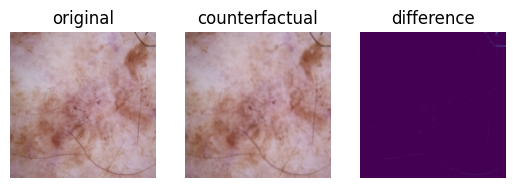

*** sample 1
[0.1147 0.3118 0.1147 0.1147 0.1147 0.1147 0.1147]
[0.1147 0.1148 0.3117 0.1148 0.1147 0.1147 0.1147]


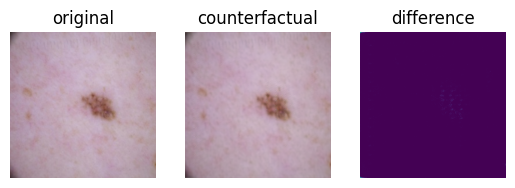

*** sample 2
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


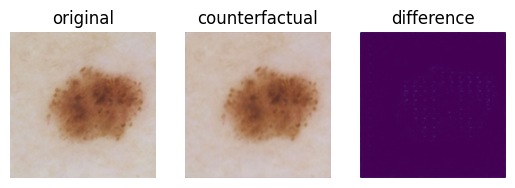

*** sample 3
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1148 0.1147]


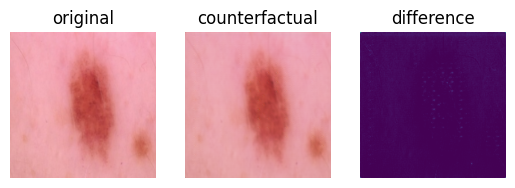

*** sample 4
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1146 0.1146 0.3116 0.1146 0.1146 0.1153 0.1146]


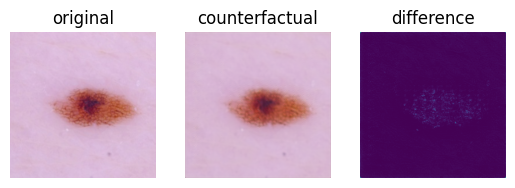

*** sample 5
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


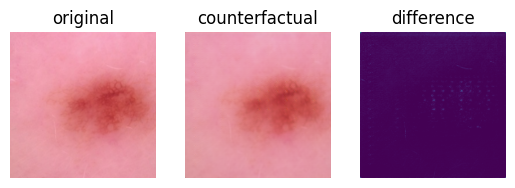

*** sample 6
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1139 0.1139 0.3095 0.1139 0.1139 0.1212 0.1139]


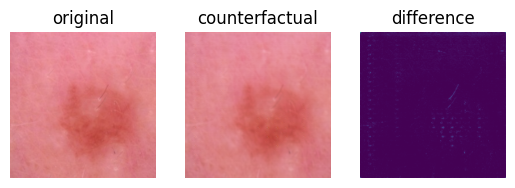

*** sample 7
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


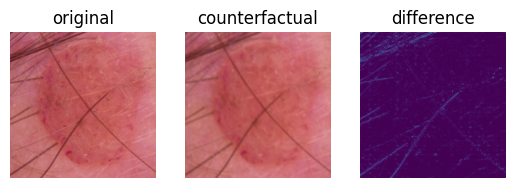

*** sample 8
[0.3118 0.1147 0.1147 0.1147 0.1147 0.1147 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


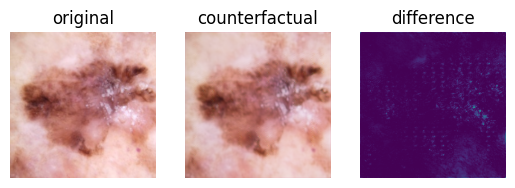

*** sample 9
[0.1139 0.1138 0.1216 0.1138 0.1138 0.3091 0.114 ]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


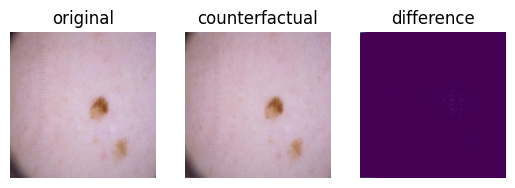

*** sample 10
[0.1108 0.1109 0.301  0.1109 0.1108 0.1448 0.1108]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


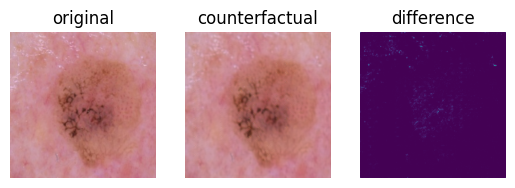

*** sample 11
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


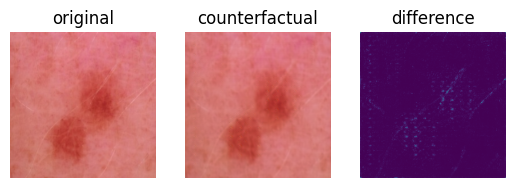

*** sample 12
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


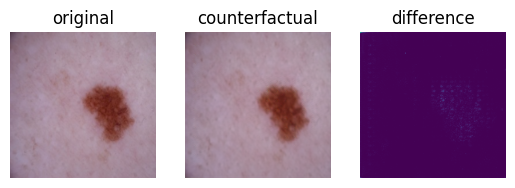

*** sample 13
[0.1309 0.3055 0.1127 0.1126 0.1131 0.1126 0.1126]
[0.1162 0.1145 0.3106 0.1147 0.1154 0.1143 0.1143]


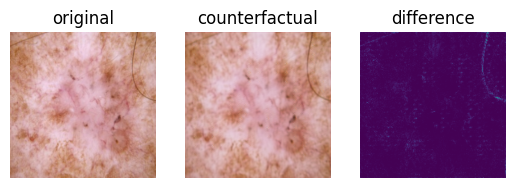

*** sample 14
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


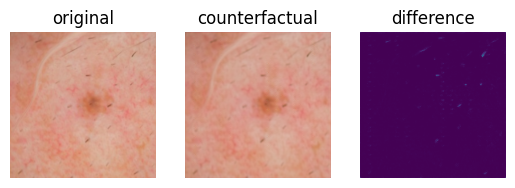

*** sample 15
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


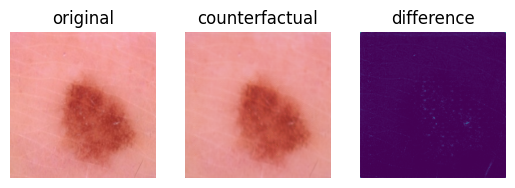

In [ ]:
plot_generated_images(train_datagen[0][0], model, classifier)

1/1 [==============================] - 0s 29ms/step
(16, 256, 256, 3) (16, 7)
*** sample 0
[0.1147 0.1147 0.115  0.1147 0.1147 0.3116 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


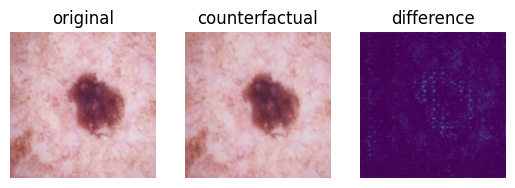

*** sample 1
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1146 0.1146 0.3116 0.1146 0.1146 0.1153 0.1146]


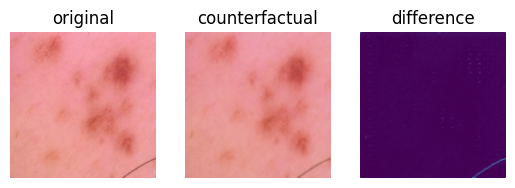

*** sample 2
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


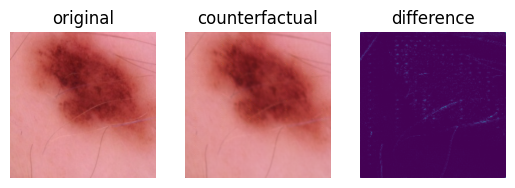

*** sample 3
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


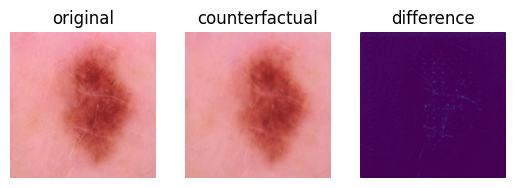

In [ ]:
plot_generated_images(train_datagen[32][0], model, classifier)

1/1 [==============================] - 0s 29ms/step
(16, 256, 256, 3) (16, 7)
*** sample 0
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


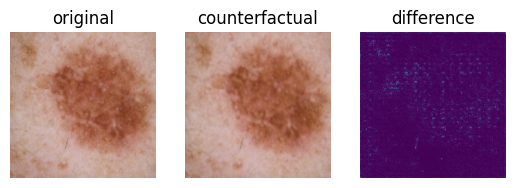

*** sample 1
[0.1147 0.1148 0.3117 0.1147 0.1147 0.1147 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


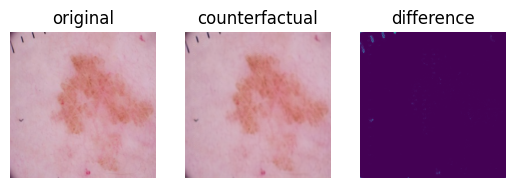

*** sample 2
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


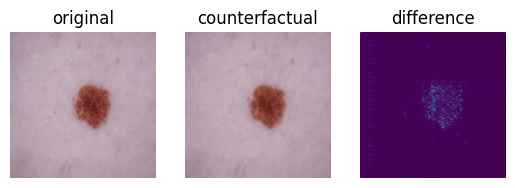

*** sample 3
[0.1147 0.1147 0.1148 0.1147 0.1147 0.3117 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


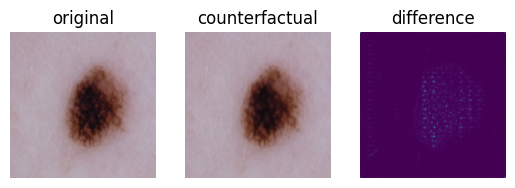

In [ ]:
plot_generated_images(train_datagen[64][0], model, classifier)

## validation

1/1 [==============================] - 0s 36ms/step
(16, 256, 256, 3) (16, 7)
*** sample 0
[0.1155 0.1201 0.1418 0.1153 0.2646 0.1275 0.1152]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


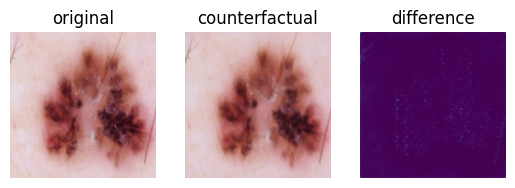

*** sample 1
[0.3117 0.1147 0.1147 0.1147 0.1147 0.1148 0.1147]
[0.1161 0.1143 0.3105 0.1143 0.1164 0.1142 0.1143]


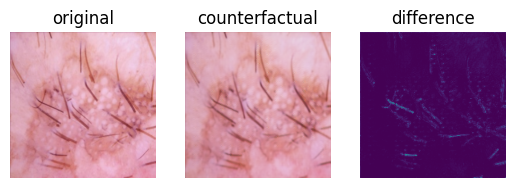

*** sample 2
[0.1374 0.1371 0.136  0.1363 0.1428 0.1744 0.1359]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


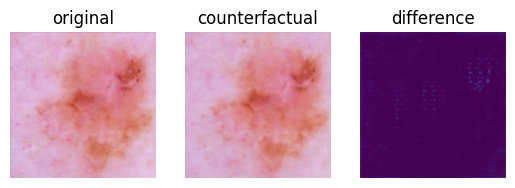

*** sample 3
[0.1097 0.1108 0.1098 0.1097 0.2122 0.2381 0.1097]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


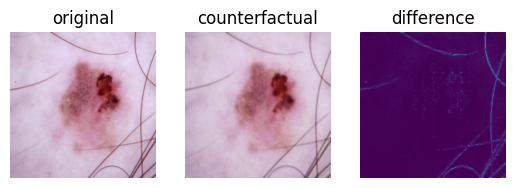

*** sample 4
[0.3118 0.1148 0.1147 0.1147 0.1147 0.1147 0.1147]
[0.1147 0.1148 0.3117 0.1148 0.1147 0.1147 0.1147]


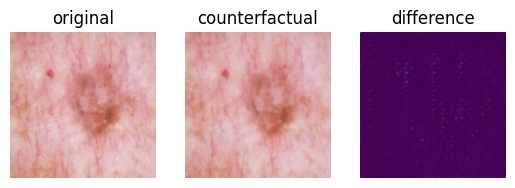

*** sample 5
[0.1128 0.1137 0.1685 0.1128 0.1154 0.264  0.1128]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


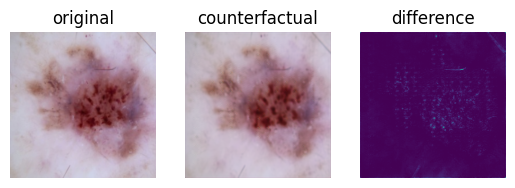

*** sample 6
[0.3117 0.1148 0.1147 0.1147 0.1147 0.1147 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


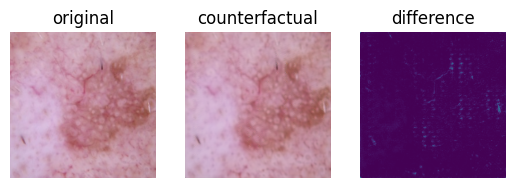

*** sample 7
[0.3016 0.111  0.1432 0.1111 0.111  0.111  0.111 ]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


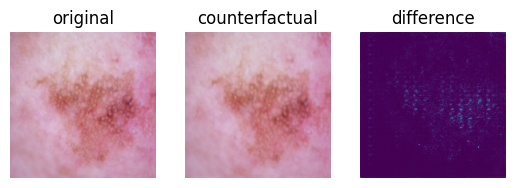

*** sample 8
[0.3118 0.1147 0.1147 0.1147 0.1147 0.1147 0.1147]
[0.1154 0.1146 0.3115 0.1146 0.1146 0.1146 0.1146]


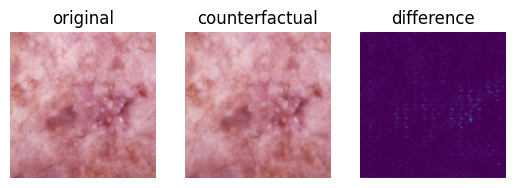

*** sample 9
[0.2978 0.1518 0.1115 0.1097 0.1097 0.1097 0.1097]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


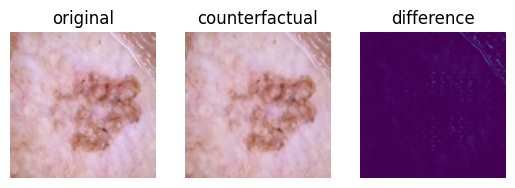

*** sample 10
[0.3118 0.1147 0.1147 0.1147 0.1147 0.1148 0.1147]
[0.1148 0.1147 0.3117 0.1147 0.1147 0.1147 0.1147]


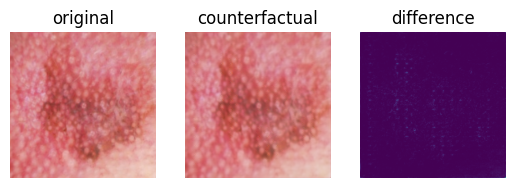

*** sample 11
[0.1997 0.1571 0.1804 0.1216 0.1142 0.1136 0.1135]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


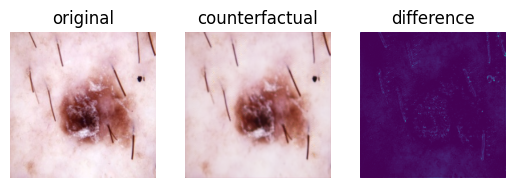

*** sample 12
[0.1067 0.2791 0.1872 0.1067 0.1068 0.1067 0.1068]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


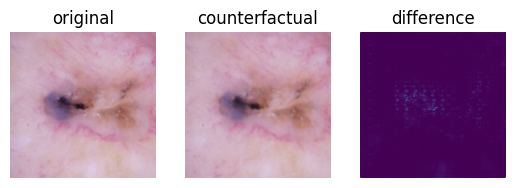

*** sample 13
[0.251  0.1135 0.1256 0.1114 0.1111 0.1766 0.1108]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


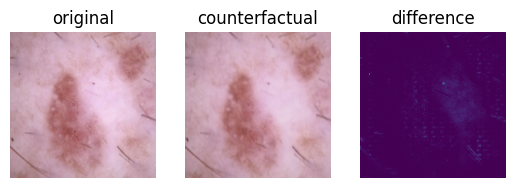

*** sample 14
[0.306  0.1126 0.1126 0.1126 0.1126 0.1309 0.1126]
[0.1152 0.1144 0.3108 0.1151 0.1159 0.1143 0.1144]


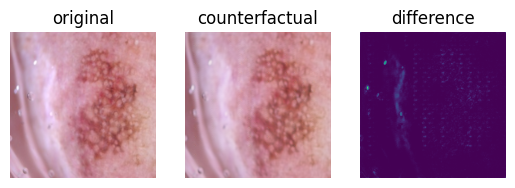

*** sample 15
[0.1962 0.2561 0.1176 0.1074 0.1067 0.1091 0.1069]
[0.1167 0.1225 0.3027 0.1142 0.1198 0.1119 0.1122]


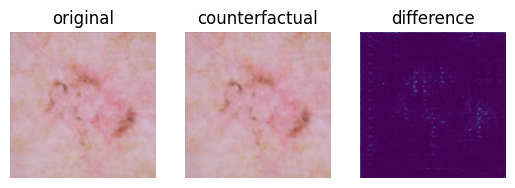

In [ ]:
plot_generated_images(val_datagen[0][0], model, classifier)

1/1 [==============================] - 0s 31ms/step
(16, 256, 256, 3) (16, 7)
*** sample 0
[0.109  0.1153 0.2599 0.1091 0.109  0.1887 0.109 ]
[0.1147 0.1147 0.3117 0.1148 0.1147 0.1147 0.1147]


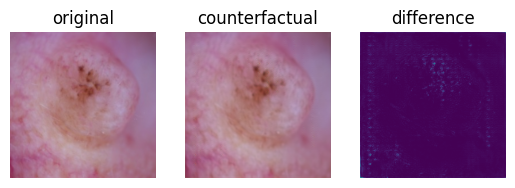

*** sample 1
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


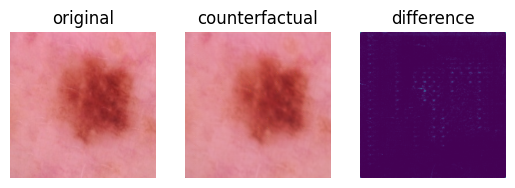

*** sample 2
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


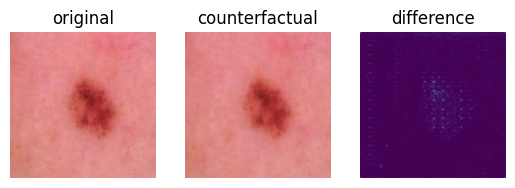

*** sample 3
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


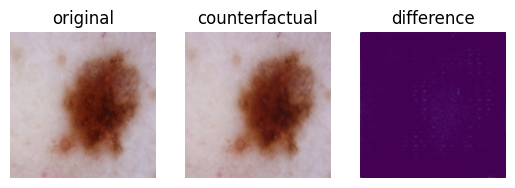

In [ ]:
plot_generated_images(val_datagen[32][0], model, classifier)

1/1 [==============================] - 0s 29ms/step
(16, 256, 256, 3) (16, 7)
*** sample 0
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3117 0.1149]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


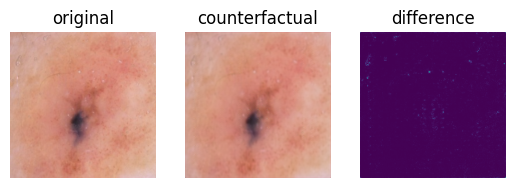

*** sample 1
[0.1145 0.1146 0.1146 0.1145 0.1145 0.3111 0.1163]
[0.1147 0.1147 0.3117 0.1147 0.1147 0.1147 0.1147]


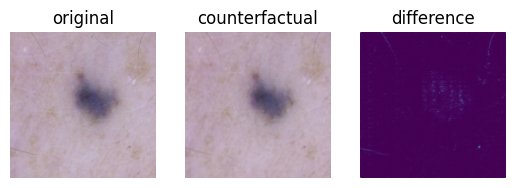

*** sample 2
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


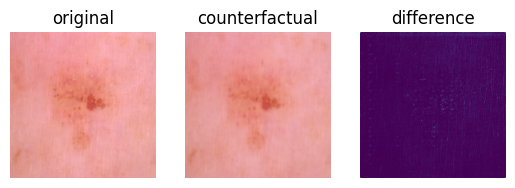

*** sample 3
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


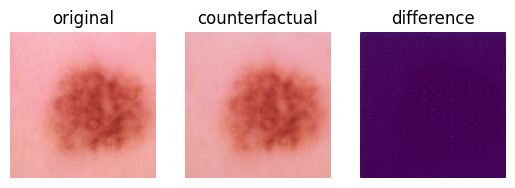

In [ ]:
plot_generated_images(val_datagen[64][0], model, classifier)

## test

1/1 [==============================] - 0s 29ms/step
(16, 256, 256, 3) (16, 7)
*** sample 0
[0.146  0.1276 0.1289 0.125  0.1311 0.2166 0.1247]
[0.1147 0.1147 0.3117 0.1147 0.1147 0.1147 0.1147]


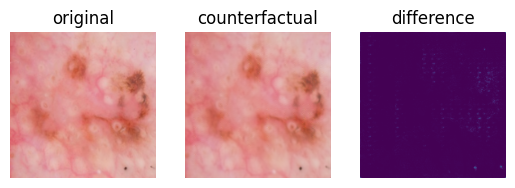

*** sample 1
[0.3098 0.1149 0.1194 0.114  0.114  0.114  0.114 ]
[0.1179 0.1146 0.3104 0.1144 0.1143 0.1142 0.1142]


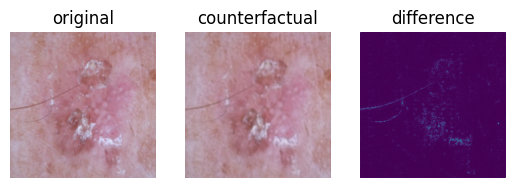

*** sample 2
[0.1147 0.3117 0.1147 0.1147 0.1147 0.1147 0.1147]
[0.1145 0.1169 0.3101 0.1154 0.1146 0.1142 0.1143]


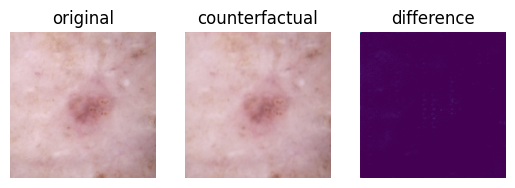

*** sample 3
[0.3116 0.115  0.1147 0.1147 0.1147 0.1147 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


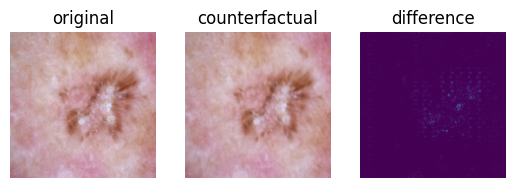

*** sample 4
[0.3118 0.1147 0.1147 0.1147 0.1147 0.1147 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


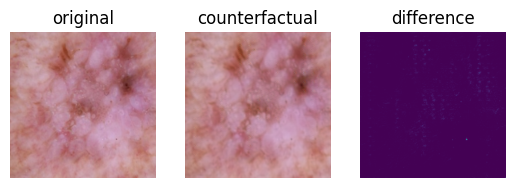

*** sample 5
[0.3118 0.1147 0.1147 0.1148 0.1147 0.1147 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


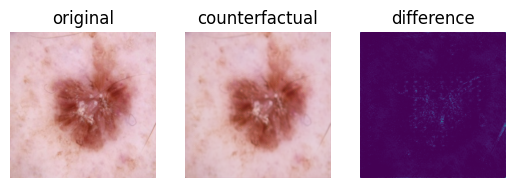

*** sample 6
[0.1111 0.1135 0.2673 0.1098 0.1098 0.1787 0.1098]
[0.1147 0.1147 0.3118 0.1148 0.1147 0.1147 0.1147]


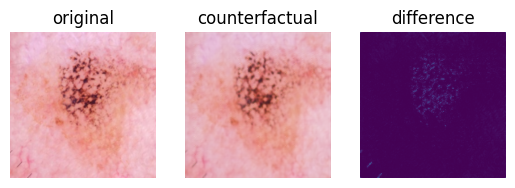

*** sample 7
[0.3047 0.1174 0.121  0.1144 0.1139 0.1146 0.114 ]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


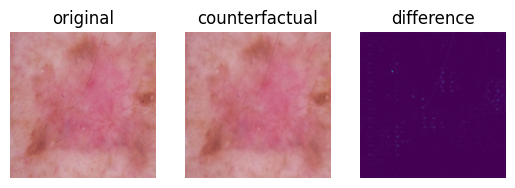

*** sample 8
[0.1304 0.1138 0.1147 0.1138 0.1146 0.299  0.1137]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


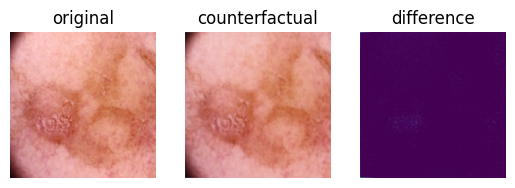

*** sample 9
[0.1561 0.2633 0.1308 0.112  0.112  0.1138 0.1121]
[0.1195 0.1182 0.3021 0.1157 0.119  0.113  0.1126]


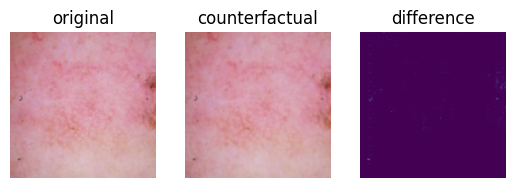

*** sample 10
[0.1195 0.1152 0.1153 0.1152 0.1166 0.3031 0.1152]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


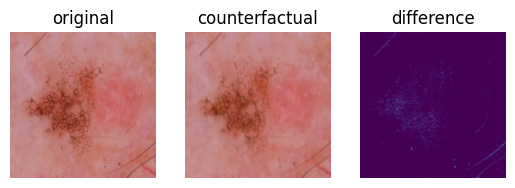

*** sample 11
[0.2673 0.2148 0.103  0.1062 0.1029 0.1029 0.1028]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


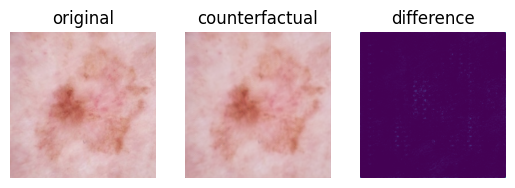

*** sample 12
[0.3118 0.1147 0.1147 0.1147 0.1147 0.1147 0.1147]
[0.1217 0.1139 0.309  0.1139 0.1142 0.1137 0.1137]


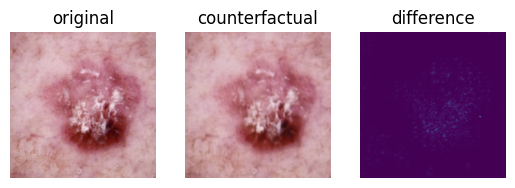

*** sample 13
[0.31   0.1197 0.114  0.1141 0.1141 0.114  0.114 ]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


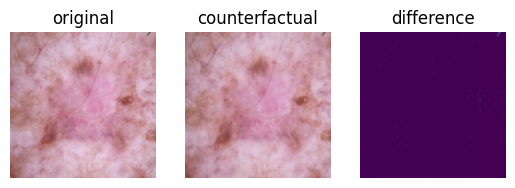

*** sample 14
[0.3115 0.1147 0.1148 0.1147 0.1149 0.1146 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


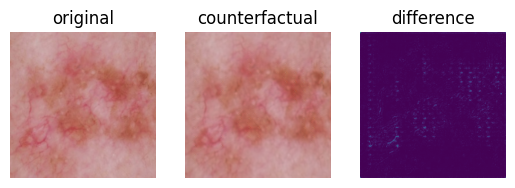

*** sample 15
[0.1278 0.1286 0.1261 0.1104 0.2864 0.1104 0.1104]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


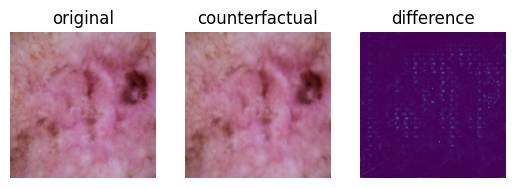

In [ ]:
plot_generated_images(test_datagen[0][0], model, classifier)

1/1 [==============================] - 0s 50ms/step
(16, 256, 256, 3) (16, 7)
*** sample 0
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


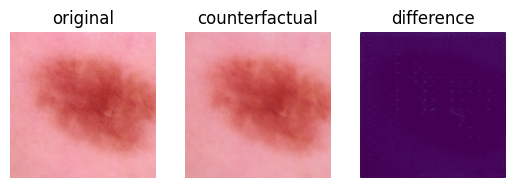

*** sample 1
[0.1146 0.1147 0.1146 0.1146 0.1152 0.3116 0.1146]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


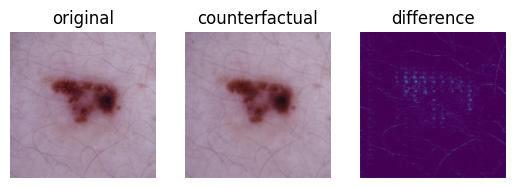

*** sample 2
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


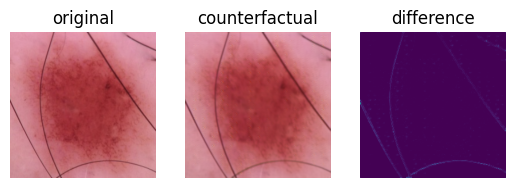

*** sample 3
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


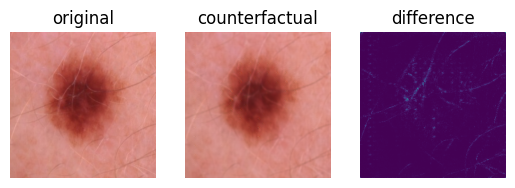

In [ ]:
plot_generated_images(test_datagen[32][0], model, classifier)

1/1 [==============================] - 0s 45ms/step
(16, 256, 256, 3) (16, 7)
*** sample 0
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


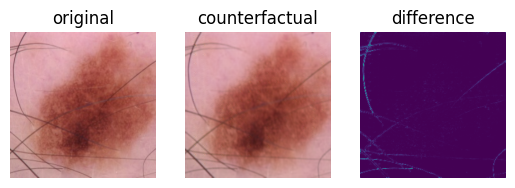

*** sample 1
[0.1148 0.1147 0.1147 0.1147 0.1147 0.3116 0.1147]
[0.1147 0.1147 0.3117 0.1148 0.1147 0.1147 0.1147]


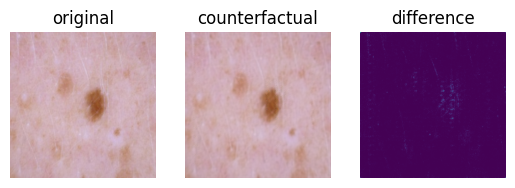

*** sample 2
[0.1147 0.1147 0.1147 0.1147 0.1147 0.3118 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


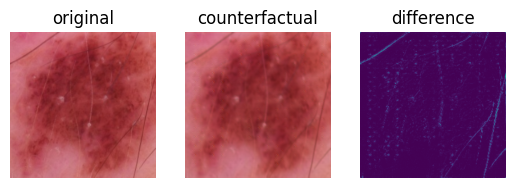

*** sample 3
[0.1147 0.1147 0.1148 0.1147 0.1147 0.3117 0.1147]
[0.1147 0.1147 0.3118 0.1147 0.1147 0.1147 0.1147]


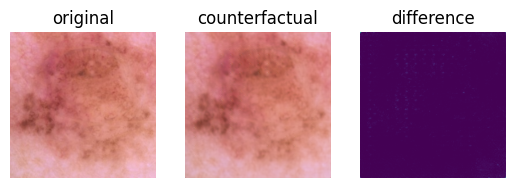

In [ ]:
plot_generated_images(test_datagen[64][0], model, classifier)

# Evaluation - Confidence Diff

In [ ]:
def compute_confidence_diff(datagen, tag_subset, generator, classifier):
    df = {'Y_cls_original':[],
          'Y_cls_counter':[]}
    for X, Ys in datagen:
        X_, _ = generator.predict(X, verbose=0)
        Y_cls_original = classifier.predict(X, verbose=0)
        Y_cls_counter = classifier.predict(X_, verbose=0)

        num = X.shape[0]
        Y_label = Ys['classifier256']
        class_ids = Y_label.argmax(axis=1)

        df['Y_cls_original'] += list(Y_cls_original[range(num), class_ids])
        df['Y_cls_counter'] += list(Y_cls_counter[range(num), class_ids])

        # print(class_ids)
        # print(Y_cls_original[range(num), class_ids])
        # print(Y_cls_counter[range(num), class_ids])

    df = pd.DataFrame(df)
    df.to_csv('eval_confidence_diff_%s.csv'%(tag_subset))

In [ ]:
compute_confidence_diff(train_datagen, 'train', model, classifier)

In [ ]:
compute_confidence_diff(val_datagen, 'val', model, classifier)

In [ ]:
compute_confidence_diff(test_datagen, 'test', model, classifier)

In [9]:
import os

def compute_result(filename):
    print(os.path.basename(filename))
    df = pd.read_csv(filename, header='infer')
    df['count_decline'] = (df['Y_cls_original'] > df['Y_cls_counter']).astype(int)
    df['percentage_decline'] = (df['Y_cls_original'] - df['Y_cls_counter']) / df['Y_cls_original']

    count_decline = df['count_decline'].sum() / df['count_decline'].count()
    percentage_decline = df[df['count_decline'] == 1]['percentage_decline'].mean()
    print('count_decline =', count_decline)
    print('percentage_decline =', percentage_decline)
    return df

In [10]:
df = compute_result(
    'outputs/confidence_diff_label_target_zero_onetenth/eval_confidence_diff_train.csv')
df = compute_result(
    'outputs/confidence_diff_label_target_zero_onetenth/eval_confidence_diff_val.csv')
df = compute_result(
    'outputs/confidence_diff_label_target_zero_onetenth/eval_confidence_diff_test.csv')

eval_confidence_diff_train.csv
count_decline = 0.907892107892108
percentage_decline = 0.6033595576855468
eval_confidence_diff_val.csv
count_decline = 0.8775
percentage_decline = 0.5571935541129089
eval_confidence_diff_test.csv
count_decline = 0.8644518272425249
percentage_decline = 0.5615014388651597
